# Digital Image Processing - HW14 - 98722278 - Mohammad Doosti Lakhani
In this notebook, I have solved the assignment's problems which are as follows:

1. Read [Cycle GAN](https://arxiv.org/abs/1703.10593) paper and report a summary.
2. Answer these questions about PCA and AutoEncoders:
    1. Supervision aspect.
    2. Trainable aspect.
    3. Compare from different aspects too.
3. Train a GAN network that uses below structure as the generator and train it on any dataset (except MNIST)

![generator](wiki/3_1.jpg)

## 1 Cycle GAN Summary
CycleGAN is an image to image translation tasks that works when paired label image for input dataset is not available. Previous models in image to image translation task such as Pix2Pix needs paired label as they try to find a one to one mapping between each pair but CycleGAN omitted this need by trying to first learning a map from X to Y and then forcing network to be able to construct input image which means learning a map from Y to X and this is the cycle in CycleGAN name.

As we know in GANs there is a generator and a discriminator (standard models) where generator tries to create images based on what mapping it learned and the duty of discriminator is to distinguish between images which being generated by the generator and real images from dataset. Both networks are trained simultaneously. When training finished, generator model learned the underlying distribution of data and can create new images that are similar to dataset in term of style.

But there is flaw in the aforementioned approach. In simplified works generator can learn only a mapping from a group of input images that causes discriminator not to be able to classify fake images from real ones and generator produces same images all the time no matter what input is. Actually, generator discard input image and discriminator fails on particular images and loss function still decreasing as no constraintion violated.

The idea of forcing network to learn a reverse mapping from Y to X in CycleGAN cause the loss to incorporate the reconstruction of input image to be similar at the end.

G1(x) = y, G2(y)=z ---> x = z

The above notations says that if a generator cannot obtain input image from the generated image from the original generator, the loss should be high. Here is the network architecture:

![CycleGAN arch](wiki/3_5.jpg)

Based on the architecture CycleGAN model works in this way:

First input image `img` is fed to first generator called `g1` and `g1` tries to map `img` to another image called `gen`. `g1` is learning a map from domain `dm1` which is for `img` to domain `dm2` which stands for `gen`. Now as we do not have any paired image in dataset, we cannot ensure that `dm2` is meaningful which means the mapping learned by `g1` can be anything. So to ensure about it, the new generated image `g1` is fed to another generator `g2` (where is the reverse of `g1` when trained) to convert back `gen` to image `img`. This forces the model to learn only the meaningful domain represented by the input `img`. Also there are two discriminator, one for each generator to enforce each generator to work well in theirs single task transformation. In other words, discriminators try to enforce two objectives: 1. Generators generate images similar to real data by generating meaningful images 2. By generating images similar to input.

Here is image of CycleGAN with implementation terms:

![CycleGAN implem](wiki/3_6.jpg)

Loss function needs to meet following constraints:

    1. Discriminator must approve all the original images
    2. Discriminator must reject all the images which are generated by corresponding Generators
    3. Generators must make the discriminators approve all the generated images
    4. The generated image must retain the property of original image, let's say if we get `gen` from `img` by `g1`, we must be able to get `img` by feeding `gen` to `g2`
    
Both discriminators want to decreas their loss regarding their real input images `D1(a)` and `D2(a)`
Both discriminators want to predict 0 for generated images so D wants to maximize `D1(G2(b))` and `D2(G1(a))`
Both generators want to fool their discriminators so G wants to minimize `D2(G1(a))` and `D1(G2(b))`
And cycle loss that enables network the generate images similar to their inputs which means the difference between input image to a generator and its output should be small as possible so we want to minimize `mean(a-ab, b-ba)` where `ab` is the output of giving `a` to `g1` then `g2` and `ba` in reverse manner.

## 2 Answer these questions about PCA and AutoEncoders:
1. Supervision aspect.
2. Trainable aspect.
3. Compare from other aspects too.

### 2.A Supervision
In PCA only features (X) are needed as the only computations are eigen values and coovariance matrix. But about Autoencoders it can be both supervised or unsupervised depending on task but generally and as what see in main AutoEncoders, they are unsupervised as they used to find hidden structure in given data distributions.

### 2.B Trianable
PCA uses eigen values and eigen vectors to find most dominant factors in given data and then just transform them into new axis system using orthogonal transforms so it is not trainable. But AutoEncoders are neural network architectures that use optimizer to train model iteratively.

### 2.C Other Aspects
First thing about PCA is that it only works on data where features are **linearly coorelated** to each other which for most of the tasks in real world it fails. But on the other hand, AutoEncoders uses conv (or fc) layers and non-linearity among them which enables it capture almost any type of corelation between two arbitrary features and based on the pattern recognition theorem, the capacity of AutoEncoders are unlimited which means they can learn any kind of corelations but the appropriate config needs to be found which is complex in practice.

![pca vs ae](wiki/2_1.png)

About similarities, they both can find correlations in features so we can skip some of features and use the **dimensionality reduction* aspect of these two approaches.

About computations, as we know that PCA is linear and AutoEncoder is non-linear, and PCA is not trainable and iterative but AutoEncoder is, so it can be obtained that AutoEncoder needs much more computational power and time.

Finding correct config for AutoEncoders is hard and almost there is no fixed approach in general and it have to be learned for different data distributins while PCA only uses statistical features of data and no configuration is needed.

## 3 Train a GAN Network
1. Import Library
2. Set Hyperparameters
3. Load Data
4. Generator
5. Discriminator
6. Compile Models
7. Train Model

![generator](wiki/3_1.jpg)



_** NOTE: in my experiments using 1024 channels in the first layer of generator hinders model to learn anything within 100 30 epochs so I changed it to smaller value such as 256 and model learned much better even in 5 epochs. **_

![train fail on 1024](wiki/3_2.jpg)

Trained generator after 30 epoch with 1024 channels:

![output 30 epoch 1024](wiki/3_3.png)

Trained generator after 30 epoch with 256 channels:

![output 30 epoch 256](wiki/3_4.png)

### 3.A Import Library

In [ ]:
%tensorflow_version 1.x

import os

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import cifar10
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras import initializers
from keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, Dense,
                          Dropout, Flatten, Input, Reshape, UpSampling2D,
                          ZeroPadding2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam

from PIL import Image, ImageDraw

### 3.B Set Hyperparameters

In [ ]:
latent_dim = 100

batch_size = 256
epochs = 200

img_rows = 32
img_cols = 32
channels = 3
kernel_size = 3

save_path = 'model'

img_rows, img_cols, channels = 32, 32, 3
img_shape = (img_rows, img_cols, channels)

optimizer = Adam(0.0002, 0.5)

if not os.path.isdir(save_path):
    os.mkdir(save_path)

### 3.C Load Data

In [23]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
print(x_train.shape)

(50000, 32, 32, 3)


### 3.D Generator

In [24]:
def create_generator():
    model = Sequential()
    
    model.add(Dense(256 * 4 * 4, input_shape=(latent_dim,)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    model.add(Conv2DTranspose(1024, kernel_size=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, kernel_size=(2, 2), strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(128, kernel_size=(2, 2), strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, kernel_size=(2, 2), strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(3, kernel_size=(2, 2), strides=1, padding='same'))
    model.add(Activation('tanh'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
generator = create_generator()
generator.summary()

# note as my dataset images are 32x32, I changed last layer of generator to output 32x32
# as interpolating this size to 64x64 is not good for training a small model like this on low epochs.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 4, 4, 1024)        1049600   
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 8, 8, 128)        

### 3.E Discriminator

In [25]:
def create_descriminator():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=kernel_size, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=kernel_size, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=kernel_size, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=kernel_size, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
discriminator = create_descriminator()
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 9, 9, 64)          0         
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 9, 9, 64)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 9, 9, 64)         

### 3.F Compile Models

In [ ]:
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

def show_images(noise, epoch=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        image = np.clip(image, 0, 1)
        plt.subplot(10, 10, i+1)
        plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    
    if epoch != None:
        plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')

### 3.G Train and Visualize Model

Epoch: 0 	 D Loss: 0.1408897191286087 	 D Acc: 0.966796875 --------------- G Loss: 2.502480983734131
Epoch: 1 	 D Loss: 0.6513555645942688 	 D Acc: 0.71875 --------------- G Loss: 1.4019020795822144
Epoch: 2 	 D Loss: 0.42379525303840637 	 D Acc: 0.83203125 --------------- G Loss: 2.179460287094116
Epoch: 3 	 D Loss: 0.31921884417533875 	 D Acc: 0.884765625 --------------- G Loss: 1.7940351963043213
Epoch: 4 	 D Loss: 0.5647900700569153 	 D Acc: 0.701171875 --------------- G Loss: 1.2438313961029053
Epoch: 5 	 D Loss: 0.5118107795715332 	 D Acc: 0.771484375 --------------- G Loss: 1.263763427734375
Epoch: 6 	 D Loss: 0.5986407995223999 	 D Acc: 0.66015625 --------------- G Loss: 1.4512063264846802
Epoch: 7 	 D Loss: 0.48800066113471985 	 D Acc: 0.78125 --------------- G Loss: 1.280998706817627
Epoch: 8 	 D Loss: 0.5552944540977478 	 D Acc: 0.716796875 --------------- G Loss: 1.3519189357757568
Epoch: 9 	 D Loss: 0.6581202745437622 	 D Acc: 0.6640625 --------------- G Loss: 1.2491165399

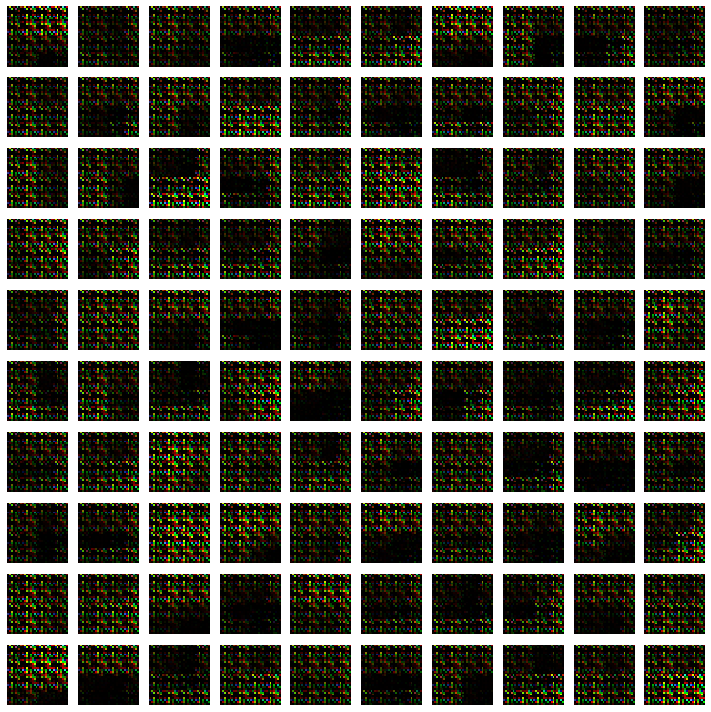

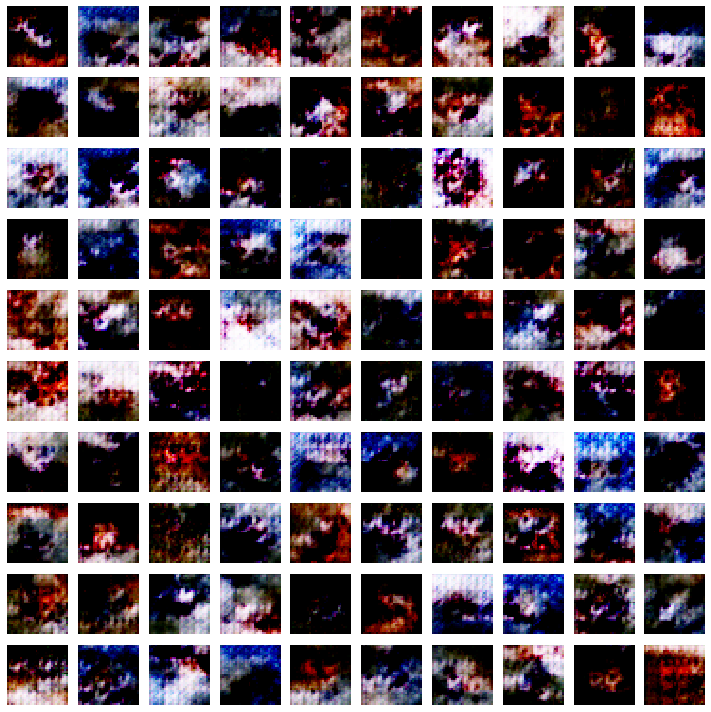

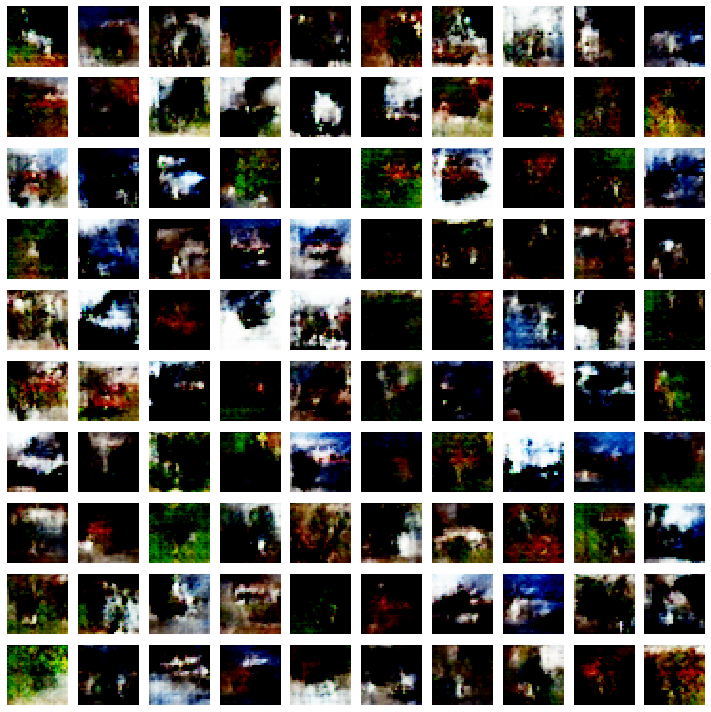

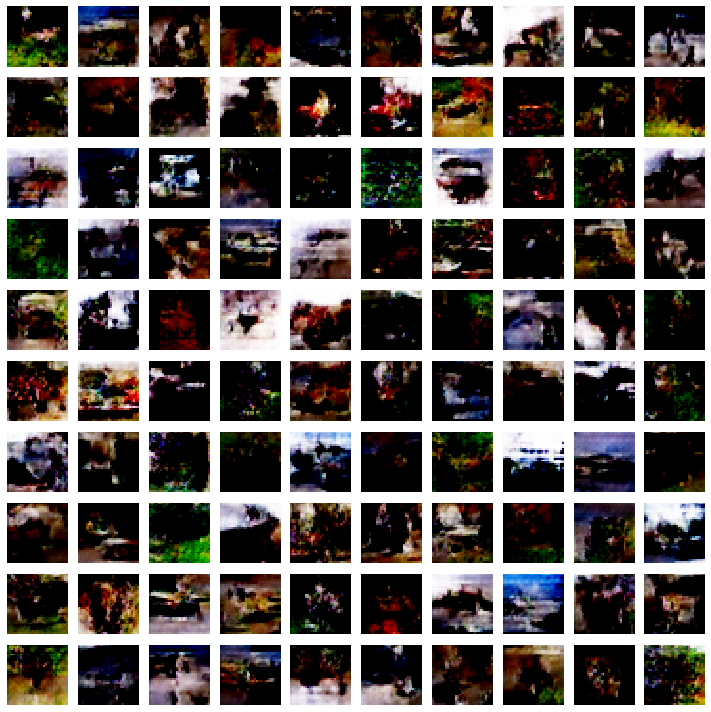

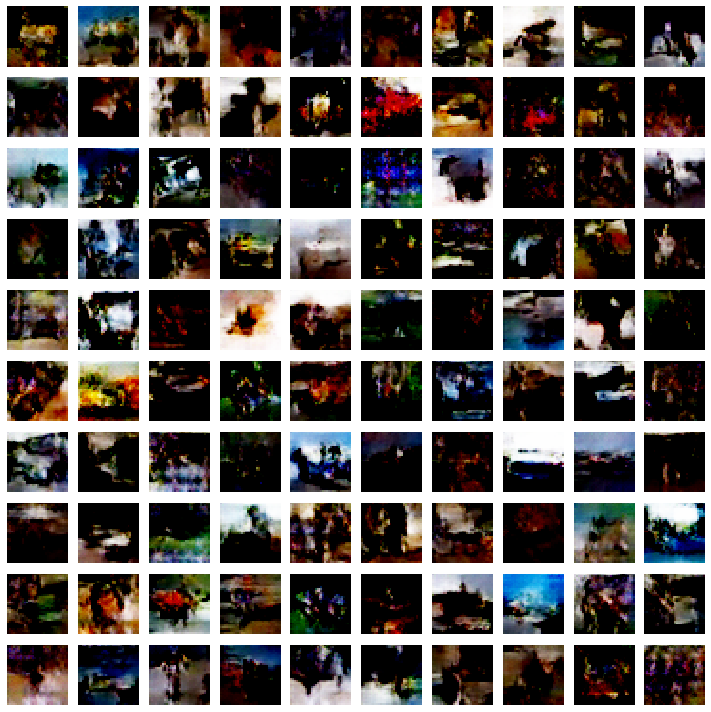

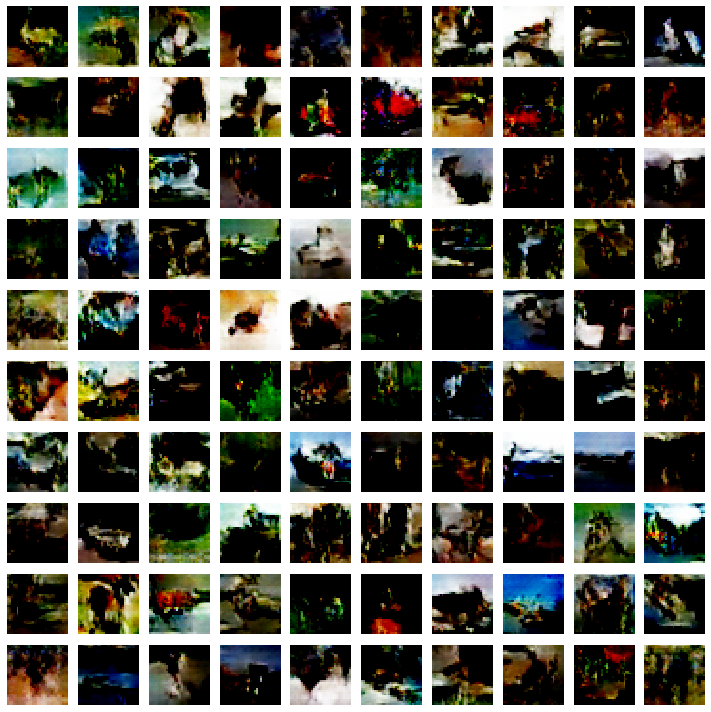

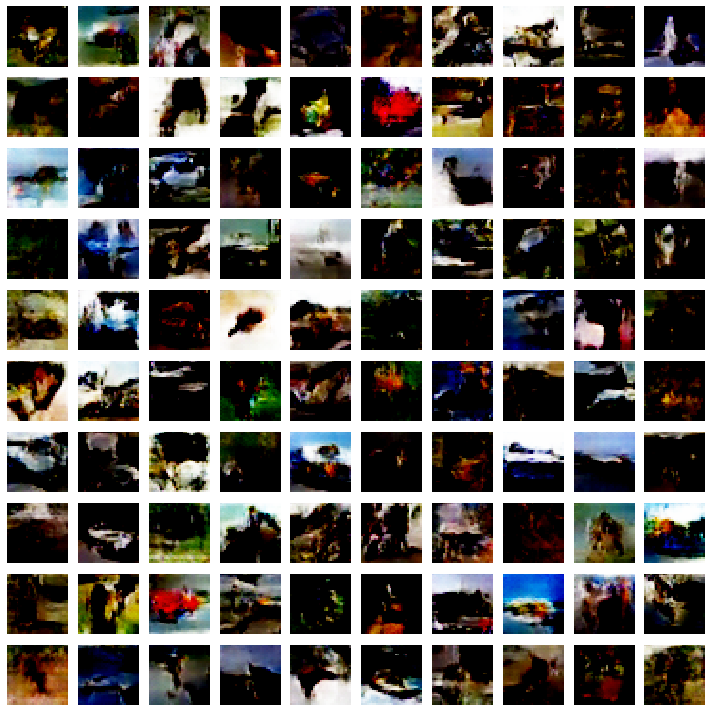

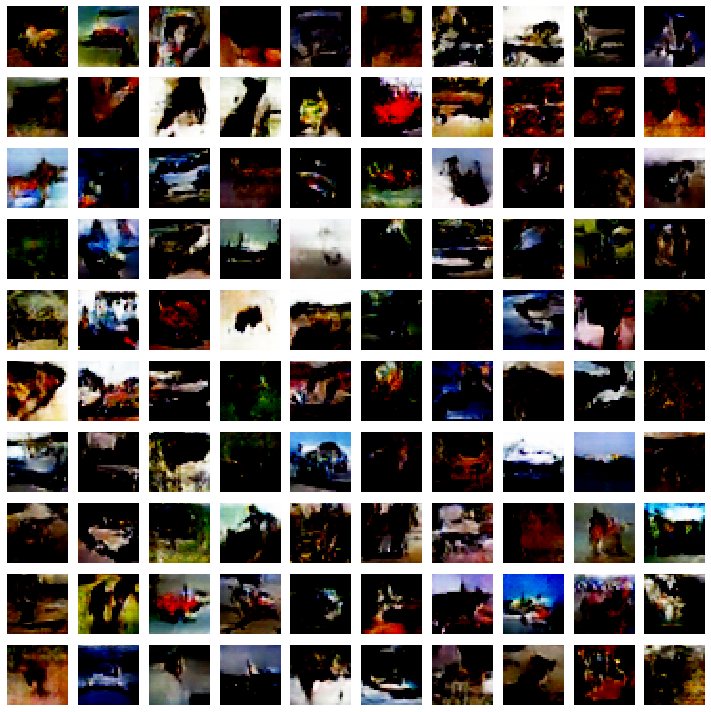

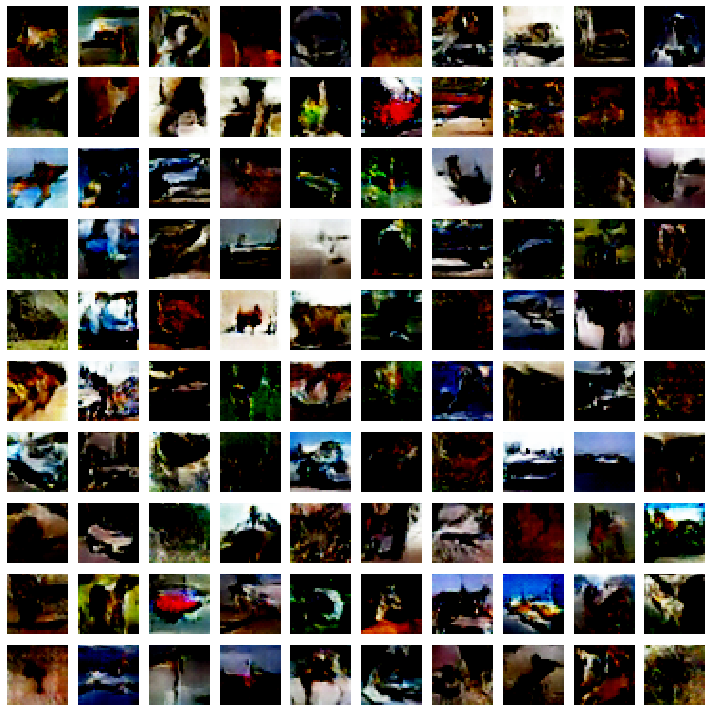

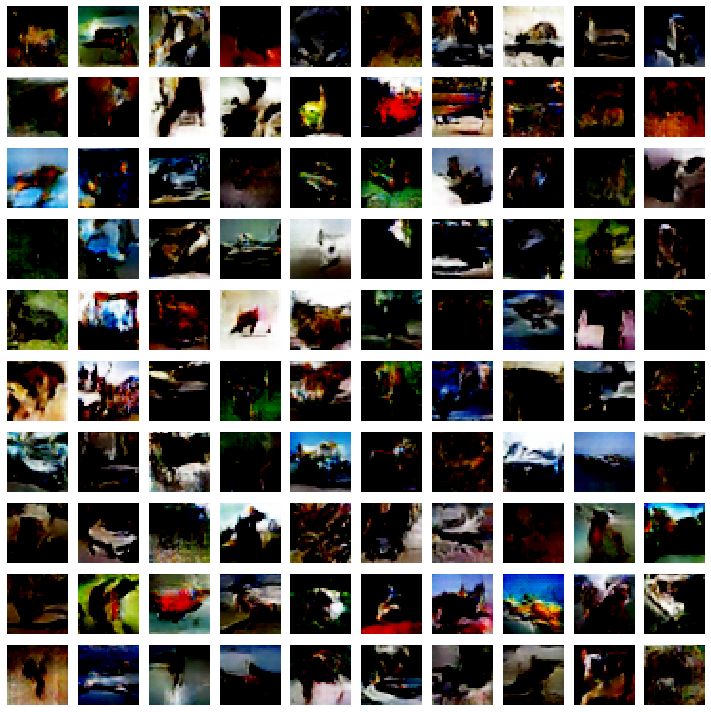

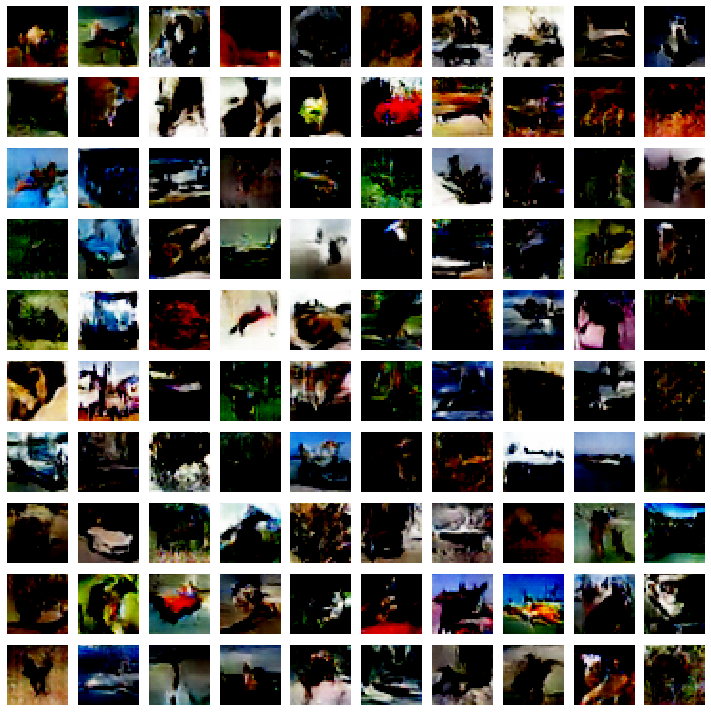

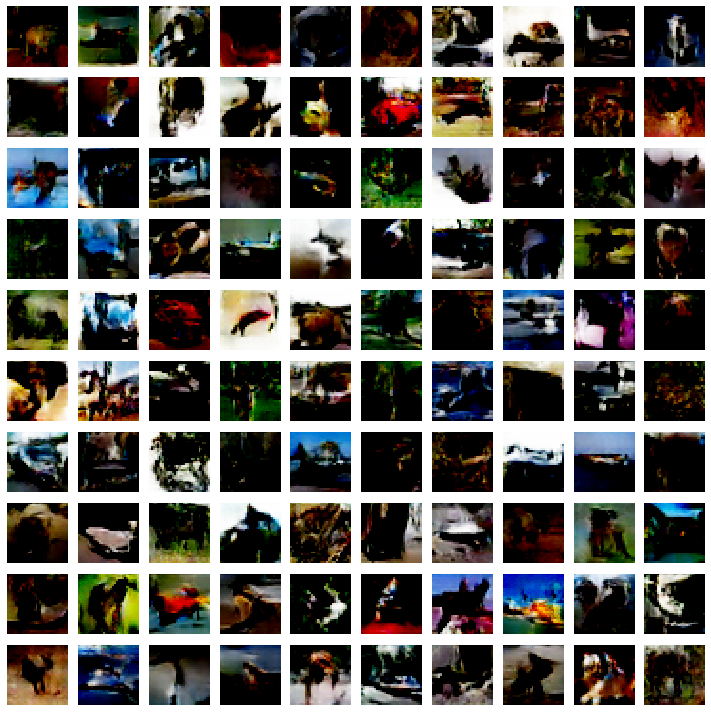

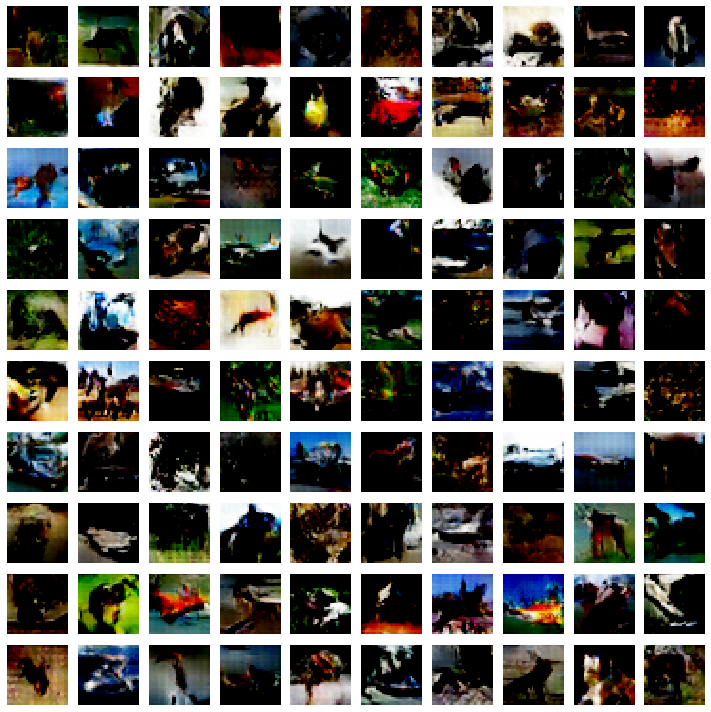

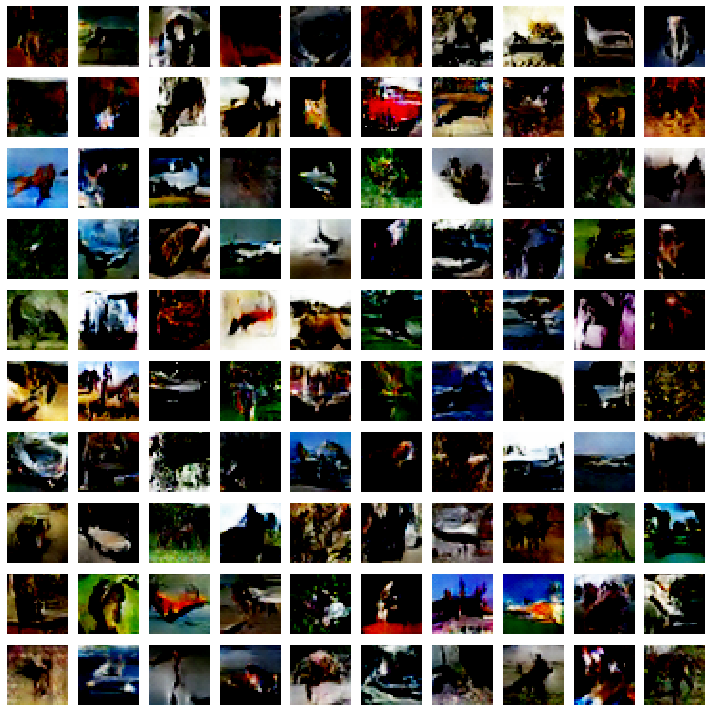

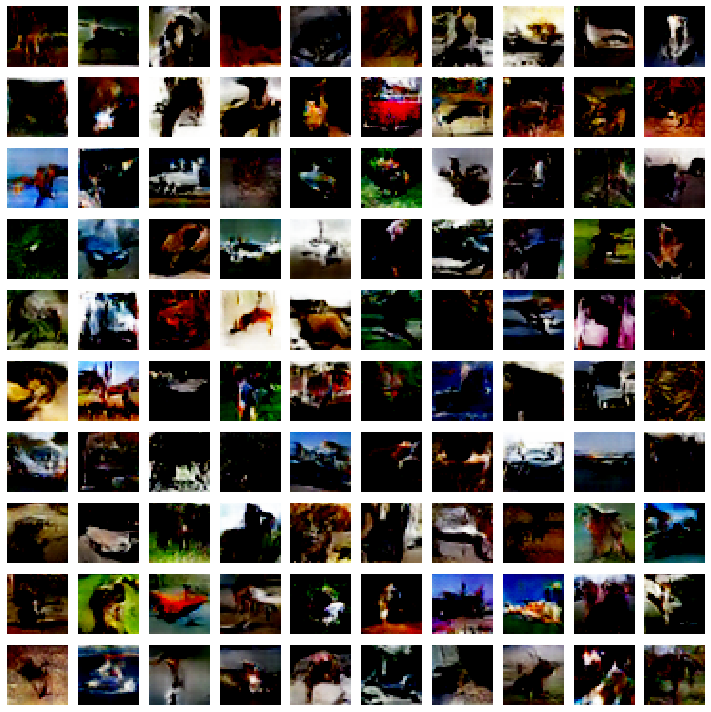

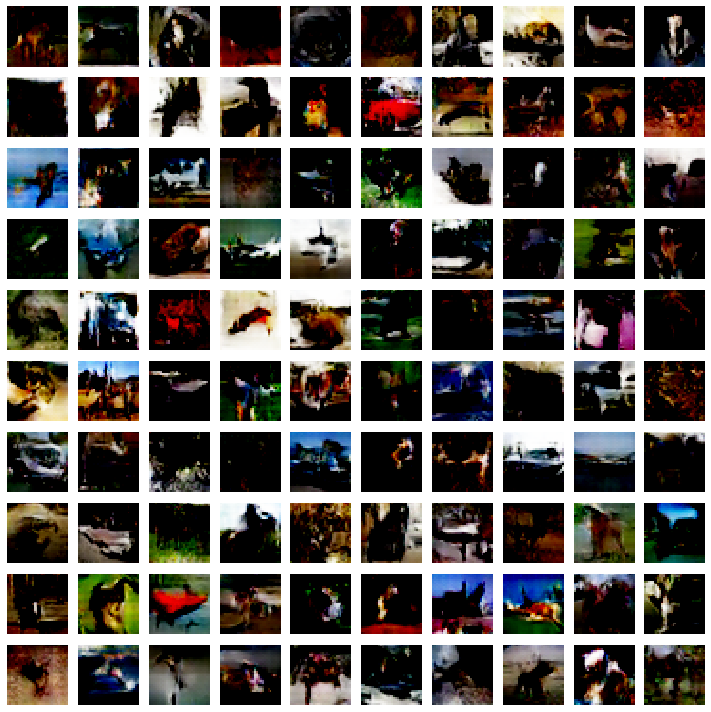

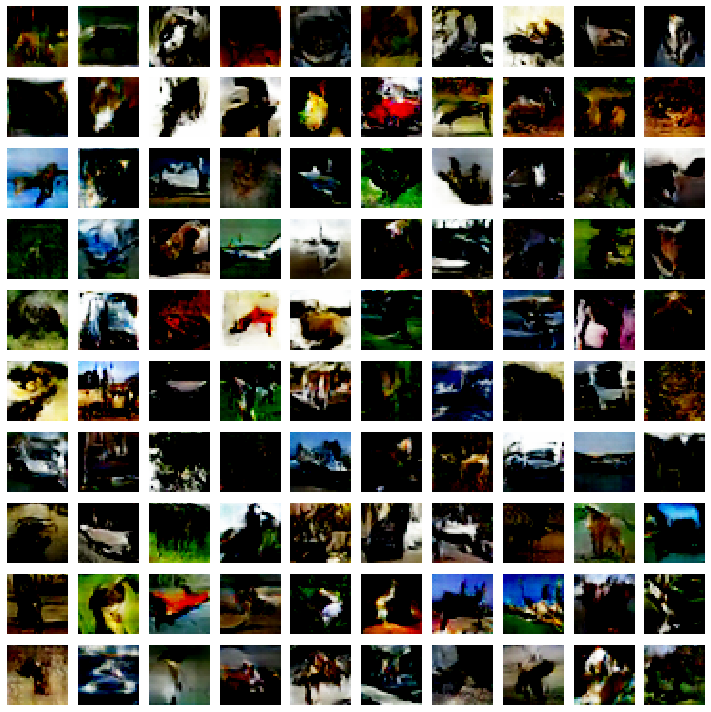

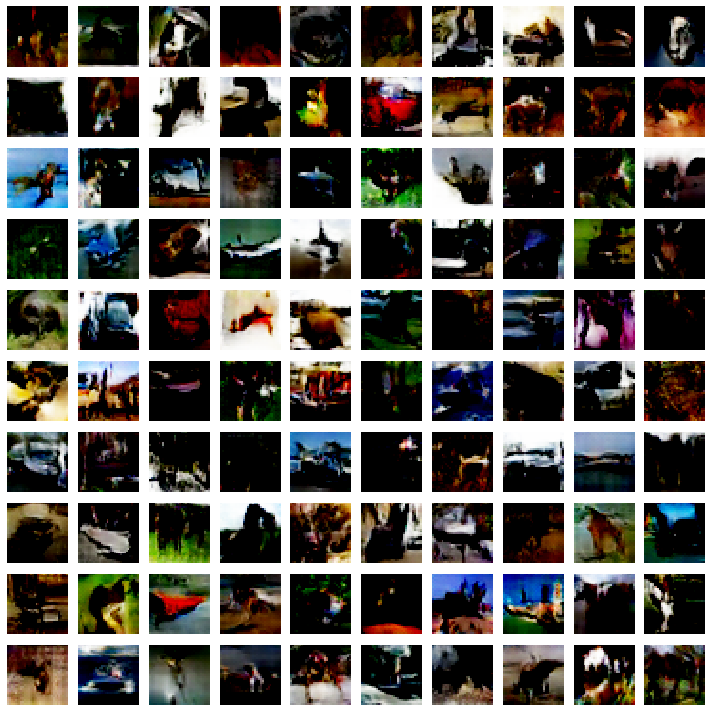

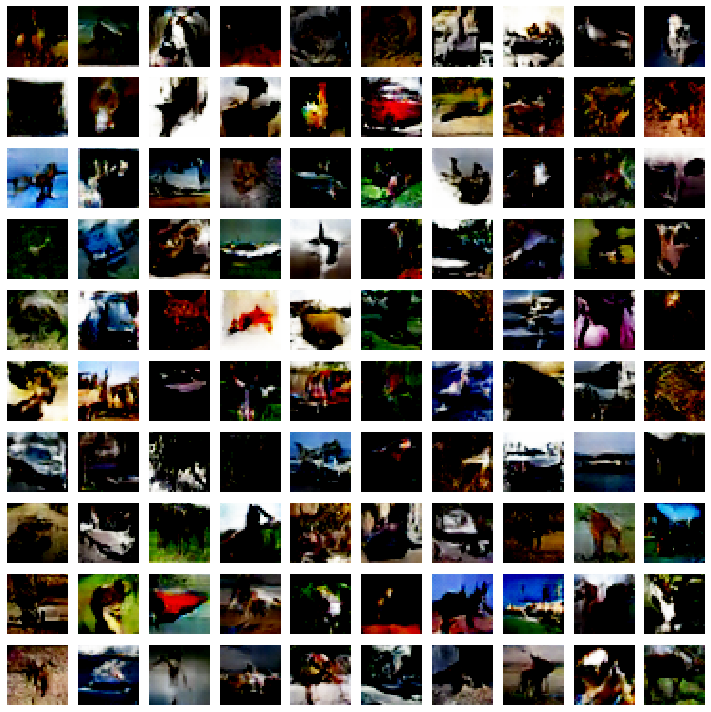

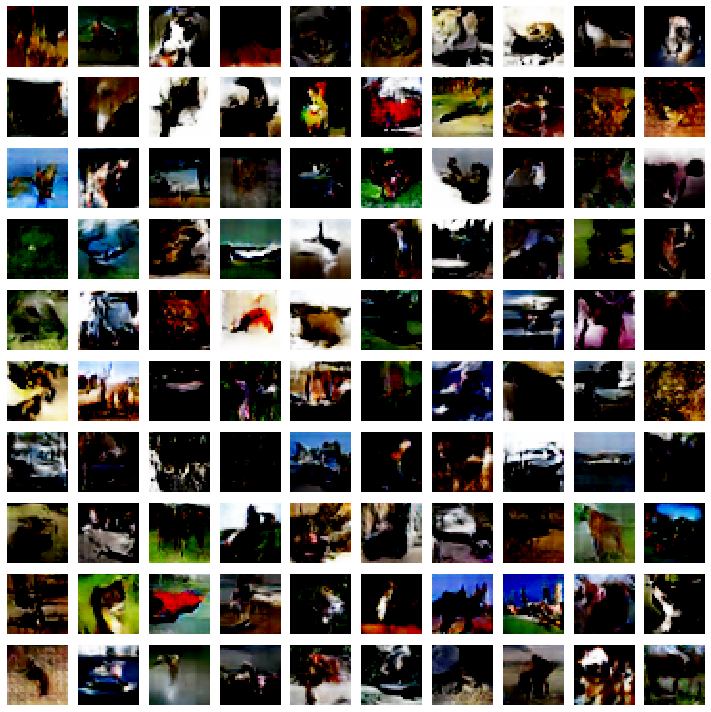

In [27]:
steps_per_epoch = x_train.shape[0]//batch_size 
static_noise = np.random.normal(0, 1, size=(100, latent_dim))

for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

        fake_x = generator.predict(noise)
        x = np.concatenate((real_x, fake_x))
        y = np.zeros(2*batch_size)
        y[:batch_size] = 1

        d_loss = discriminator.train_on_batch(x, y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch} \t D Loss: {d_loss[0]} \t D Acc: {d_loss[1]} --------------- G Loss: {g_loss[0]}')
    if epoch % 10 == 0:
        show_images(static_noise, epoch)


image_names = os.listdir(save_path)[:-1]

frames = []
for image in sorted(image_names, key=lambda name: int(''.join(i for i in name if i.isdigit()))):
    frames.append(Image.open(save_path + '/' + image))